In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

import os
import random
from PIL import Image, ImageEnhance, ImageFilter

from IPython.display import Image as ImagePy
from IPython.core.display import HTML 
from collections import Counter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset Preparation

Our dataset folder looks like this:

In camera filtered, we have 8 filters: sepia, brightness, contrast, black_and_white, cool, warmth, cool_hue, and warm_hue.

We will add 3 more filters: saturation, brilliance, and exposure.

# Add Saturation, Brilliance, and Exposure

In [3]:
base_dir = 'dataset'
camera_filters = ["saturation", "brilliance", "exposure"]

camera_filtered_dir = os.path.join(base_dir, 'camera_filtered')
os.makedirs(camera_filtered_dir, exist_ok=True)

def apply_varied_saturation_filter(img):
    enhancer = ImageEnhance.Color(img)
    factor = random.uniform(1.2, 2.0)
    saturated_img = enhancer.enhance(factor)
    return saturated_img

def apply_varied_brilliance_filter(img):
    brightness_enhancer = ImageEnhance.Brightness(img)
    brightness_factor = random.uniform(1.2, 2.0)
    img = brightness_enhancer.enhance(brightness_factor)
    
    contrast_enhancer = ImageEnhance.Contrast(img)
    contrast_factor = random.uniform(1.2, 2.0)
    brilliant_img = contrast_enhancer.enhance(contrast_factor)
    
    return brilliant_img

def apply_varied_exposure_filter(img):
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(1.2, 2.0)
    exposed_img = enhancer.enhance(factor)
    return exposed_img

def apply_camera_filter(img, filter_name):
    if filter_name == "saturation":
        return apply_varied_saturation_filter(img)
    elif filter_name == "brilliance":
        return apply_varied_brilliance_filter(img)
    elif filter_name == "exposure":
        return apply_varied_exposure_filter(img)
    else:
        return img

def process_and_save_images(source_dir, target_dir, filter_name, cap):

    all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    selected_files = random.sample(all_files, min(cap, len(all_files)))
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        with Image.open(source_path) as img:
            filtered_img = apply_camera_filter(img, filter_name)
            target_file_dir = os.path.join(target_dir, filter_name)
            os.makedirs(target_file_dir, exist_ok=True)
            filtered_img.save(os.path.join(target_file_dir, file))

for subdir, cap in [('train', 86744), ('val', 3000)]:
    source_subdir = os.path.join(base_dir, 'unfiltered', subdir)
    target_subdir = os.path.join(camera_filtered_dir, subdir)
    for filter_name in camera_filters:
        print("Adding " + filter_name + " " + subdir)
        process_and_save_images(source_subdir, target_subdir, filter_name, cap)

Adding saturation train
Adding brilliance train
Adding exposure train
Adding saturation val
Adding brilliance val
Adding exposure val


# Count images per folder

In [ ]:
def count_images(folder):
    files = os.listdir(folder)
    images = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    return len(images)
    
camera_filtered = 'dataset/camera_filtered'

for subdir in ['train', 'val']:
    subdir_path = os.path.join(camera_filtered, subdir)
    for filter_name in ["brightness", "contrast", "sepia", "black_and_white", "cool", "warmth", "warm_hue", "cool_hue", "brilliance", "saturation", "exposure"]:
        filter_dir = os.path.join(subdir_path, filter_name)
        num_images = count_images(filter_dir)
        print(f"Number of {filter_name} images in {subdir}: {num_images}")

# Define Dataset Class

In [2]:
from torch.utils.data import Dataset
from torchvision import transforms

class BinaryDataset(Dataset):
    def __init__(self, unfiltered_dir, filtered_dir, filter_name, split='train', transform=None):
        self.transform = transform

        self.image_paths = []
        self.image_labels = []

        unfiltered_path = os.path.join(unfiltered_dir, split)
        for img_name in os.listdir(unfiltered_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(unfiltered_path, img_name))
                self.image_labels.append(0)

        filtered_path = os.path.join(filtered_dir, split, filter_name)
        if os.path.exists(filtered_path):
            for img_name in os.listdir(filtered_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(filtered_path, img_name))
                    self.image_labels.append(1)
        else:
            print(f"No such filter folder: {filtered_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


# Define Helper Functions

###  Evaluate the model

In [11]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
            total_loss += loss.item()
            predicted = outputs.round()
            correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy



### Test model on test data

In [18]:
class TestFilteredUnfilteredDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.samples = []

        unfiltered_dir = os.path.join(base_dir, 'unfiltered')
        self.samples += [(os.path.join(unfiltered_dir, f), 0) for f in os.listdir(unfiltered_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        filtered_dir = os.path.join(base_dir, 'filtered')
        self.samples += [(os.path.join(filtered_dir, f), 1) for f in os.listdir(filtered_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float)

### Display incorrect and all predictions

In [30]:
def evaluate_and_display_incorrect_predictions(model, data_loader, device):
    model.eval()
    incorrect_images = []
    incorrect_preds = []
    incorrect_actuals = []
    
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            incorrect_mask = predicted.squeeze() != labels.squeeze()
            incorrect_images.extend(images[incorrect_mask].cpu())
            incorrect_preds.extend(predicted[incorrect_mask].cpu().numpy())
            incorrect_actuals.extend(labels[incorrect_mask].cpu().numpy())

    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Number of incorrect predictions: {len(incorrect_images)}")

    for i, image in enumerate(incorrect_images):
        img = transforms.ToPILImage()(image)
        plt.figure(figsize=(2, 2))
        plt.imshow(img)
        plt.title(f'Actual: {int(incorrect_actuals[i])}, Pred: {int(incorrect_preds[i])}')
        plt.axis('off')
        plt.show()

def display_all_predictions(model, data_loader, device, images_per_row=5):
    model.eval()
    total_images = len(data_loader.dataset)
    rows = (total_images + images_per_row - 1) // images_per_row  

    plt.figure(figsize=(20, rows * 4))

    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)  
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            for img_idx, image in enumerate(images):
                ax = plt.subplot(rows, images_per_row, idx * data_loader.batch_size + img_idx + 1)
                img = transforms.ToPILImage()(image.cpu())
                ax.imshow(img)
                ax.set_title(f'Actual: {int(labels[img_idx].cpu())}, Pred: {int(predicted[img_idx].cpu())}')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, filter_name, num_epochs=20, checkpoint_dir='checkpoints_camera_binary'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_accuracy = correct_preds / total_preds
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                predicted = torch.sigmoid(outputs) > 0.5
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
                val_running_loss += loss.item()

        val_accuracy = val_correct_preds / val_total_preds
        val_loss = val_running_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        checkpoint_path = os.path.join(checkpoint_dir, f'{filter_name}_{epoch+1}.pth')
        print(f"Saving checkpoint to {checkpoint_path}")
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')

# Define Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryCNNModel(nn.Module):
    def __init__(self):
        super(BinaryCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(6)
        self.fc = nn.Linear(6 * 32 * 32, 1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(x)
        x = self.bn1(self.dropout1(x))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = BinaryCNNModel().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

# Exposure

In [28]:
unfiltered_train = "dataset/unfiltered"
unfiltered_val = "dataset/unfiltered"

filtered_dir = "dataset/camera_filtered"
filter_name = "exposure"

train_dataset = BinaryDataset(unfiltered_dir=unfiltered_train, filtered_dir=filtered_dir, filter_name=filter_name, split='train', transform=transform)
val_dataset = BinaryDataset(unfiltered_dir=unfiltered_val, filtered_dir=filtered_dir, filter_name=filter_name, split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


print("Train")
label_counts = Counter(train_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')
print("Val")
label_counts = Counter(val_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Train
Label 0: 86744 images
Label 1: 86744 images
Val
Label 0: 10954 images
Label 1: 10954 images


In [29]:
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Before Training - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Before Training - Val Loss: 0.7121, Val Accuracy: 0.5000


In [ ]:
checkpoint_dir = 'checkpoints_camera_binary'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            device=device, 
            filter_name=filter_name,
            num_epochs=20, 
            checkpoint_dir='checkpoints_camera_binary')


Accuracy: 100.00%
Number of incorrect predictions: 0


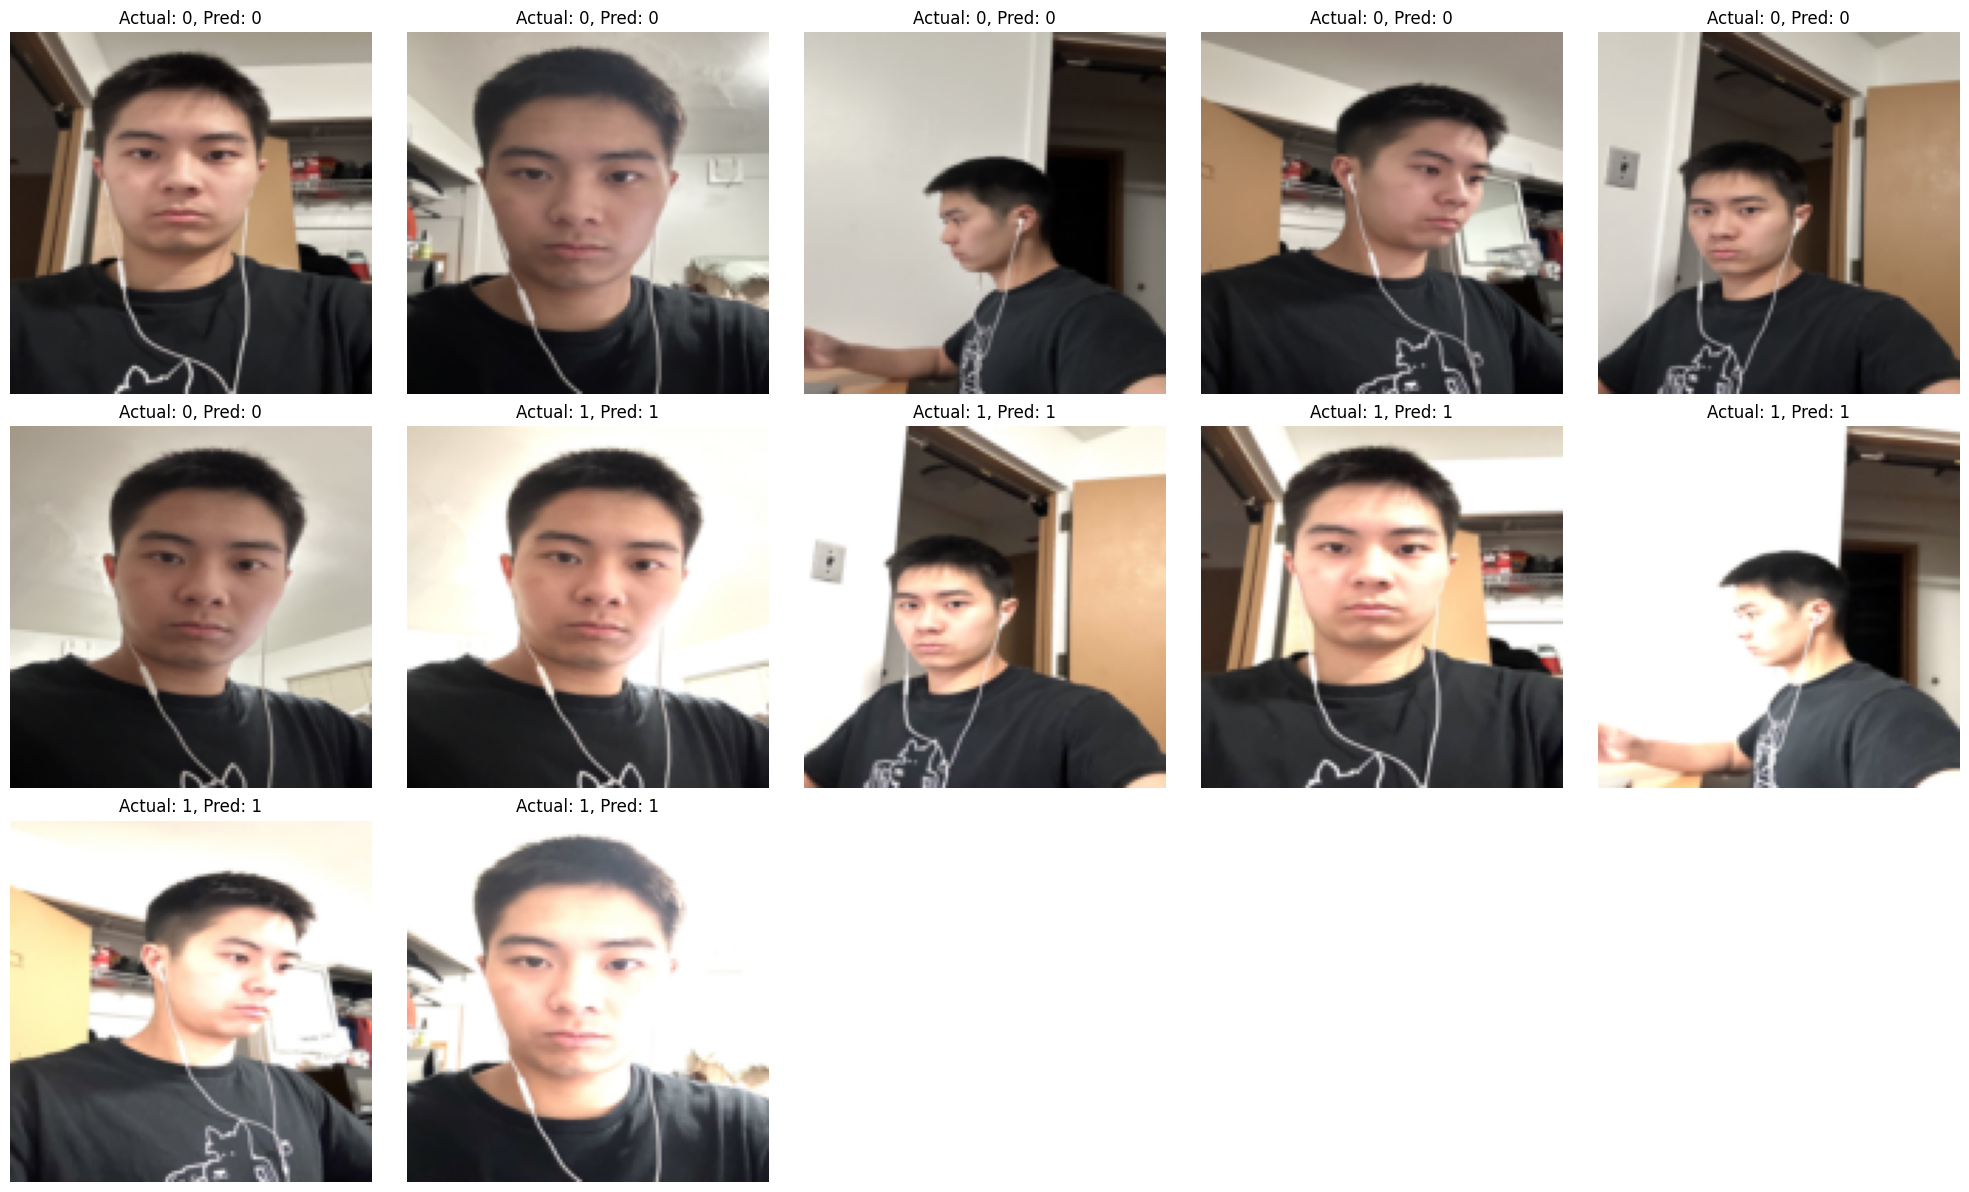

In [32]:
checkpoint_path = 'checkpoints_camera_binary/exposure_9.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

data_dir = 'camera_test_datasets/exposure'
test_dataset = TestFilteredUnfilteredDataset(base_dir=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_and_display_incorrect_predictions(model, test_loader, device)
display_all_predictions(model, test_loader, device)

Good.

# Using Deeper Model for Black and White

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpdatedBinaryCNNModel(nn.Module):
    def __init__(self):
        super(UpdatedBinaryCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding='same') 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(16 * 32 * 32 // 4, 1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act1(self.conv2(x)))
        x = self.bn2(self.dropout1(x))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
model = BinaryCNNModel().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

# Black and White

In [ ]:
unfiltered_train = "dataset/unfiltered"
unfiltered_val = "dataset/unfiltered"

filtered_dir = "dataset/camera_filtered"
filter_name = "black_and_white"

train_dataset = BinaryDataset(unfiltered_dir=unfiltered_train, filtered_dir=filtered_dir, filter_name=filter_name, split='train', transform=transform)
val_dataset = BinaryDataset(unfiltered_dir=unfiltered_val, filtered_dir=filtered_dir, filter_name=filter_name, split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


print("Train")
label_counts = Counter(train_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')
print("Val")
label_counts = Counter(val_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Before Training - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

checkpoint_dir = 'checkpoints_camera_binary'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            device=device, 
            filter_name=filter_name,
            num_epochs=20, 
            checkpoint_dir='checkpoints_camera_binary')

Train
Label 0: 86744 images
Label 1: 86744 images
Val
Label 0: 10954 images
Label 1: 10954 images
Before Training - Val Loss: 0.6953, Val Accuracy: 0.5000


In [ ]:
checkpoint_path = 'checkpoints_camera_binary/black_and_white_1.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

data_dir = 'camera_test_datasets/black_and_white'
test_dataset = TestFilteredUnfilteredDataset(base_dir=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_and_display_incorrect_predictions(model, test_loader, device)
display_all_predictions(model, test_loader, device)

# Warmth

In [ ]:
unfiltered_train = "dataset/unfiltered"
unfiltered_val = "dataset/unfiltered"

filtered_dir = "dataset/camera_filtered"
filter_name = "warmth"

train_dataset = BinaryDataset(unfiltered_dir=unfiltered_train, filtered_dir=filtered_dir, filter_name=filter_name, split='train', transform=transform)
val_dataset = BinaryDataset(unfiltered_dir=unfiltered_val, filtered_dir=filtered_dir, filter_name=filter_name, split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


print("Train")
label_counts = Counter(train_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')
print("Val")
label_counts = Counter(val_dataset.image_labels)
for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Before Training - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

checkpoint_dir = 'checkpoints_camera_binary'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_model(model=model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            device=device, 
            filter_name=filter_name,
            num_epochs=20, 
            checkpoint_dir='checkpoints_camera_binary')

In [ ]:
checkpoint_path = 'checkpoints_camera_binary/model1_tests_13.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])


data_dir = 'camera_test_datasets/warmth'
test_dataset = TestFilteredUnfilteredDataset(base_dir=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_and_display_incorrect_predictions(model, test_loader, device)
display_all_predictions(model, test_loader, device)